In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import pystan

In [81]:
original_data = pd.read_csv('groceries.csv').iloc[:, 4:]
data = original_data.iloc[1:]
data.iloc[:, 2:] = data.iloc[:, 2:].astype(float)
data = data.reset_index(drop=True)
data.head()


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 4,Unnamed: 5,Apples,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Bananas,Unnamed: 13,...,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Chicken breasts,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65
0,ALDI,Lichtenberg,0.88,2.2,1,1.88,0.6,1.89,1,1.69,...,6,1.59,10,1.59,0.6,3.99,1,5.99,NaN,NaN
1,ALDI,Neukölln,1,2.99,1,1.79,0.8,1.89,1,1.15,...,10,1.19,6,1.59,0.6,3.99,1,5.99,0.35,3.99
2,ALDI,Neukölln,2,2.49,1,1.79,1,1.15,1,1.15,...,10,1.19,6,1.59,0.6,3.99,1,5.99,NaN,NaN
3,ALDI,Kreuzberg,1,2.99,1,1.79,1,2.29,1,1.15,...,10,1.19,6,1.59,0.6,3.99,0.4,2.99,0.4,2.79
4,ALDI,Kreuzberg,0.6,1.95,2,2.29,1,1.39,1,1.69,...,10,1.19,6,1.59,0.35,2.99,0.6,3.99,1,5.99


In [157]:
name = data.iloc[:, :2]
name.columns = ['store', 'address']
products = []
for i in list(original_data.columns):
    if 'Unnamed' not in i:
        products.append(i)
brand = range(3)
df = pd.DataFrame(np.arange(2520).reshape((84,30)), 
            index = range(84),
            columns=['' for i in range(30)])
df.columns = pd.MultiIndex.from_product([products, brand])
new = name.join(df)

indexNames = new[new.store == 'Lotte Mart'].index
indexNames2 = new[new.store == 'Safeway'].index
new.drop(indexNames, inplace=True)
new.drop(indexNames2, inplace=True)
data.drop(indexNames, inplace=True)
data.drop(indexNames2, inplace=True)

for i in range(len(new)):
    for j in range(2, 32):
        if pd.isnull(data.iloc[i, 2*j-1]) == False:
            new.iloc[i, j] = data.iloc[i, 2*j-1] / data.iloc[i, 2*j-2]
        else:
            new.iloc[i, j] = np.nan
# new.store = pd.Categorical(new.store).codes
# new.address = pd.Categorical(new.address).codes
new.store, mapping_index_1 = pd.Series(new.store).factorize()
new.address, mapping_index_2 = pd.Series(new.address).factorize()
print(data.shape)
print(new.shape)
# (new.head())
data_ = [[new.iloc[j, i] for j in range(len(new))] for i in range(2, 32)]
store_ = [[new.iloc[j, 0] for j in range(len(new))] for i in range(2, 32)]
loc_ = [[new.iloc[j, 1] for j in range(len(new))] for i in range(2, 32)]

data_= np.array(data_)
store_= np.array(store_)
loc_= np.array(loc_)

for i in range(len(data_)):
    for j in range(len(data_[i])):
        if pd.isna(data_[i, j]):
            data_[i, j] = 0


print(len(data_), len(data_[0]))
print(len(store_), len(store_[0]))
print(len(loc_), len(loc_[0]))

/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:543: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


(79, 62)
(79, 32)
30 79
30 79
30 79


In [123]:
print(data_)

[[ 2.5         2.99        1.245      ...  5.5         2.9
   2.55      ]
 [ 1.88        1.79        1.79       ...  3.3         2.55
   2.9       ]
 [ 3.15        2.3625      1.15       ...  6.4         2.32
   2.32      ]
 ...
 [ 6.65        6.65        6.65       ...  6.23       14.75
   9.15555556]
 [ 5.99        5.99        5.99       ...  9.24        7.15
  11.33333333]
 [ 0.         11.4         0.         ...  6.03        9.81
  16.        ]]


In [149]:
stan_data = {
    'data_set': data_,
    'store_set': store_,
    'loc_set': loc_,
    'num_col': 30,
    'num_row': 79,
    'num_pro': 10,
    'num_store': 7,
    'num_loc': 25,
    'pro_1': 0,
    'pro_2': 1000,
    'loc_1': 1,
    'loc_2': 0.1,
    'store_1': 1,
    'store_2': 0.1,
    'sig1': 0.3,
    'sig2': 0.2,}

In [150]:
stan_code = '''

data {
    int<lower=0> num_col;
    int<lower=0> num_row;
    int<lower=0> num_pro;
    int<lower=0> num_store;
    int<lower=0> num_loc;
    real<lower=0> pro_1;
    real<lower=0> pro_2;
    real<lower=0> loc_1;
    real<lower=0> loc_2;
    real<lower=0> store_1;
    real<lower=0> store_2;
    real<lower=0> sig1;
    real<lower=0> sig2;
    real<lower=0> data_set[num_col, num_row];
    int<lower=0> store_set[num_col, num_row];
    int<lower=0> loc_set[num_col, num_row];
}

parameters {
    vector<lower=0>[num_pro] product;
    vector<lower=0>[num_pro] sigma2;
    vector<lower=0>[num_store] store;
    vector<lower=0>[num_loc] location;
}

model {
    product ~ uniform(pro_1, pro_2);
    sigma2 ~ normal(sig1, sig2);
    store ~ cauchy(store_1, store_2);
    location ~ cauchy(loc_1, loc_2);
    for (i in 1:num_pro) {
        for (j in 1:num_row) {
            if (data_set[i*3-2, j] != 0)
            data_set[i*3-2, j] ~ normal(product[i]*store[store_set[i*3-2, j]+1]*location[loc_set[i*3-2, j]+1], sigma2[i])
            ;
            if (data_set[i*3-1, j] != 0) 
            data_set[i*3-1, j] ~ normal(product[i]*store[store_set[i*3-1, j]+1]*location[loc_set[i*3-1, j]+1], sigma2[i])
            ;
            if (data_set[i*3-2, j] != 0) 
            data_set[i*3, j] ~ normal(product[i]*store[store_set[i*3, j]+1]*location[loc_set[i*3, j]+1], sigma2[i])
            ;
        }
    }
}
'''



In [151]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1ff2a833e4c3d673e6617e08b1de35e5 NOW.


In [152]:
results = stan_model.sampling(data=stan_data)

In [153]:
print(results)

Inference for Stan model: anon_model_1ff2a833e4c3d673e6617e08b1de35e5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
product[1]     3.04    0.01   0.29   2.47   2.85   3.03   3.23    3.6    543   1.01
product[2]     1.97  9.3e-3   0.31   1.41   1.76   1.97   2.16    2.6   1088    1.0
product[3]     4.76    0.02   0.45   3.86   4.46   4.76   5.07   5.65    500   1.01
product[4]     1.41  5.8e-3   0.13   1.15   1.33   1.41    1.5   1.68    515   1.01
product[5]     1.25  5.4e-3   0.16   0.95   1.14   1.25   1.35   1.57    863   1.01
product[6]     3.57    0.01   0.33    2.9   3.36   3.57   3.78   4.24    506   1.01
product[7]     1.22  5.1e-3   0.12   0.98   1.13   1.22    1.3   1.47    586   1.01
product[8]     8.31    0.03   0.72   6.88   7.84   8.31   8.79   9.73    462   1.01
product[9]     0.31  1.3e-3   0.03   0.25   0.29   0.31

In [164]:
samples = results.extract()
berlin = [[samples['location'][:, i]] for i in range(9)]

In [165]:
print(berlin)

[[array([1.07883994, 1.13535275, 1.10662657, ..., 1.00522841, 0.99156376,
       1.14343538])], [array([1.04609518, 1.11392091, 1.10586735, ..., 0.9747775 , 1.04347639,
       1.08784328])], [array([0.95868812, 1.00133564, 1.02007397, ..., 0.9295491 , 0.96950846,
       0.92111223])], [array([0.92741196, 1.00435781, 1.03659759, ..., 0.73615865, 0.97632532,
       0.96866817])], [array([0.88743303, 0.93883671, 0.91372254, ..., 0.85335156, 0.89049531,
       0.8843024 ])], [array([0.98134051, 1.05498775, 1.06451741, ..., 0.96341362, 0.96677996,
       1.01400077])], [array([0.98240896, 1.0875769 , 0.93441096, ..., 0.9404131 , 0.98070316,
       0.94525416])], [array([0.92740211, 0.95077816, 1.05554721, ..., 0.85496512, 0.9548381 ,
       0.95072662])], [array([1.04667841, 1.12724546, 1.10225763, ..., 1.15208066, 1.08868842,
       1.07893755])]]


In [158]:
print(mapping_index_1)
print(mapping_index_2)

Index(['ALDI', 'EDEKA', 'Lidl', 'REWE', 'Sainsbury's', 'Tesco Express',
       'Waitrose & Partners'],
      dtype='object')
Index(['Lichtenberg', 'Neukölln', 'Kreuzberg', 'Alt-Treptow', 'Friedrichshain',
       'Mitte', 'Tempelhof', 'Schöneberg', 'Prenzlauer Berg', 'The Angel',
       'Fitzrovia', 'Southwark', 'Mayfair', 'Hoxton', 'Cheap', 'Farringdon',
       'Islington', 'Briton Ferry', 'Cazenove', 'Shoreditch', 'Temple',
       'Barbican', 'Marylebone', 'Kings Cross', 'Crouch End'],
      dtype='object')


In [166]:
rental_berlin = {'Lichtenberg': 9.64, 'Neukölln': 10.09, 'Kreuzberg': 12.99, 'Alt-Treptow': 9.61, 'Friedrichshain': 12.99,
       'Mitte': 12.5, 'Tempelhof': 10.26, 'Schöneberg': 10.26, 'Prenzlauer Berg': 14.5}

multi_berlin = {}
for i in range(9):
    multi_berlin[mapping_index_2[i]] = berlin[i]

In [167]:
print(multi_berlin)

{'Lichtenberg': [array([1.07883994, 1.13535275, 1.10662657, ..., 1.00522841, 0.99156376,
       1.14343538])], 'Neukölln': [array([1.04609518, 1.11392091, 1.10586735, ..., 0.9747775 , 1.04347639,
       1.08784328])], 'Kreuzberg': [array([0.95868812, 1.00133564, 1.02007397, ..., 0.9295491 , 0.96950846,
       0.92111223])], 'Alt-Treptow': [array([0.92741196, 1.00435781, 1.03659759, ..., 0.73615865, 0.97632532,
       0.96866817])], 'Friedrichshain': [array([0.88743303, 0.93883671, 0.91372254, ..., 0.85335156, 0.89049531,
       0.8843024 ])], 'Mitte': [array([0.98134051, 1.05498775, 1.06451741, ..., 0.96341362, 0.96677996,
       1.01400077])], 'Tempelhof': [array([0.98240896, 1.0875769 , 0.93441096, ..., 0.9404131 , 0.98070316,
       0.94525416])], 'Schöneberg': [array([0.92740211, 0.95077816, 1.05554721, ..., 0.85496512, 0.9548381 ,
       0.95072662])], 'Prenzlauer Berg': [array([1.04667841, 1.12724546, 1.10225763, ..., 1.15208066, 1.08868842,
       1.07893755])]}


In [175]:
berlin_sorted = sorted(rental_berlin, key=rental_berlin.get)

In [189]:
rental_berlin_2 = {}
for i in range(0, 9):
    rental_berlin_2[berlin_sorted[i]] = i+1

rental_berlin_3 = {}
for i in range(0, 9):
    rental_berlin_3[berlin_sorted[i]] = rental_berlin[berlin_sorted[i]]

['Alt-Treptow',
 'Lichtenberg',
 'Neukölln',
 'Tempelhof',
 'Schöneberg',
 'Mitte',
 'Kreuzberg',
 'Friedrichshain',
 'Prenzlauer Berg']

In [184]:
rental_berlin_2

{'Alt-Treptow': 1,
 'Lichtenberg': 2,
 'Neukölln': 3,
 'Tempelhof': 4,
 'Schöneberg': 5,
 'Mitte': 6,
 'Kreuzberg': 7,
 'Friedrichshain': 8,
 'Prenzlauer Berg': 9}

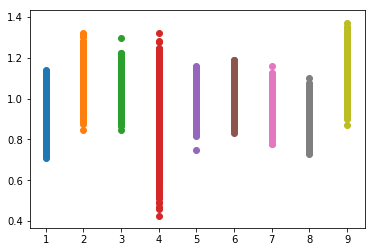

In [187]:
for each in berlin_sorted:
    plt.scatter([rental_berlin_2[each] for i in range(4000)], multi_berlin[each])

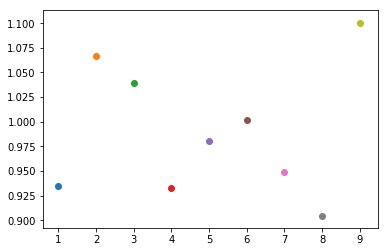

In [188]:
for each in berlin_sorted:
    plt.scatter(rental_berlin_2[each], np.mean(multi_berlin[each]))

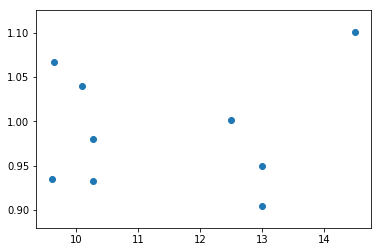

In [190]:
plt.scatter([rental_berlin_3[each] for each in berlin_sorted], [np.mean(multi_berlin[each]) for each in berlin_sorted])